# Emotion Detection in Song Lyrics (P6)

# Francesco Lazzara

# ID: 942830

The project aims at studying song lyrics under the emotional profile.

- Dataset: *WASSA-2017* Training and Development set
- Evaluation Strategy: *Cross-Validation* using the Training set

In [1]:
# Import the libraries needed for the analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emoji
import re
import nltk
import nltk.data
import tensorflow as tf
import json
import requests
import base64
import datetime
from urllib.parse import urlencode
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from textblob import TextBlob
from gingerit.gingerit import GingerIt
from string import punctuation
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Embedding, Input, Bidirectional, Dropout, GlobalMaxPooling1D
from keras import Model, Sequential
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras import regularizers
from keras.utils import np_utils
from lime.lime_text import LimeTextExplainer

---

## Exploratory Data Analysis and Text Pre-processing

Inspect the distribution of the "Intensity" for each emotion, plus build some functions to clean and POS tag the tweets. Then, other additional analysis are performed, like the "Subjectivity" and "Polarity" of the tweets, along with the *WordCloud*.

In [2]:
# Import the TRAINING SET provided for four emotions: "anger", "fear", "joy" and "sadness"

col_names = ["Index_Counter", "Tweet", "Emotion", "Intensity"]

anger_tr = pd.read_csv("anger-ratings-0to1.train.txt", sep="	", header=None, names=col_names)
fear_tr = pd.read_csv("fear-ratings-0to1.train.txt", sep="	", header=None, names=col_names)
joy_tr = pd.read_csv("joy-ratings-0to1.train.txt", sep="	", header=None, names=col_names)
sadness_tr = pd.read_csv("sadness-ratings-0to1.train.txt", sep="	", header=None, names=col_names)

emotion_tr = pd.concat([anger_tr, fear_tr, joy_tr, sadness_tr], axis=0, ignore_index=True)

print(anger_tr.shape, fear_tr.shape, joy_tr.shape, sadness_tr.shape)
print('\nSize of the aggregate Training set: {}'.format(emotion_tr.shape))

(857, 4) (1147, 4) (823, 4) (786, 4)

Size of the aggregate Training set: (3613, 4)


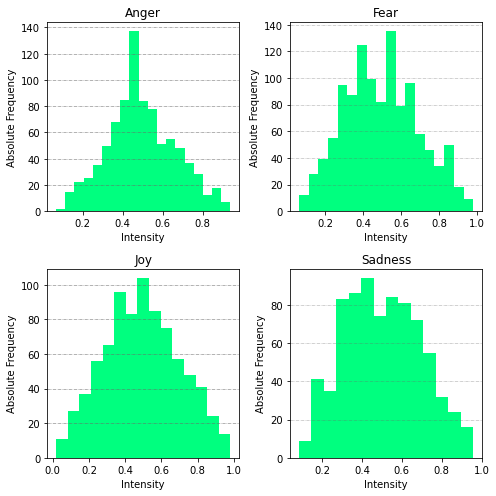

In [3]:
# Display the grid of Histograms for each sentiment and the corresponding intensity

fig1, f1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=False, tight_layout=True, figsize=(7,7))
f1_axes[0, 0].hist(x=anger_tr["Intensity"], bins="auto", color="springgreen")
f1_axes[0, 1].hist(x=fear_tr["Intensity"], bins="auto", color="springgreen")
f1_axes[1, 0].hist(x=joy_tr["Intensity"], bins="auto", color="springgreen")
f1_axes[1, 1].hist(x=sadness_tr["Intensity"], bins="auto", color="springgreen")
for plot in range(2):
    f1_axes[plot, 0].set_xlabel("Intensity")
    f1_axes[plot, 0].set_ylabel("Absolute Frequency")
    f1_axes[plot, 0].grid(b=True, color="dimgray", linestyle="-.", linewidth=0.5, axis="y")
    f1_axes[plot, 1].set_xlabel("Intensity")
    f1_axes[plot, 1].set_ylabel("Absolute Frequency")
    f1_axes[plot, 1].grid(b=True, color="dimgray", linestyle="-.", linewidth=0.5, alpha=0.6, axis="y")
    if plot == 0:
        f1_axes[plot, 0].set_title("Anger")
        f1_axes[plot, 1].set_title("Fear")
    else:
        f1_axes[plot, 0].set_title("Joy")
        f1_axes[plot, 1].set_title("Sadness")
plt.show()

In [4]:
# Remove punctuation (string) + numbers + mentions +/- stopwords (boolean) +/- emoji (boolean)

def clean_up(dataf, text, str_punct, remove_stopwd=False, remove_emoji=True):
    clean_dataf = dataf.copy()
    tk = TweetTokenizer()
    stopwd = stopwords.words("english")
    clean_txt = []

    if text == "Tweet":
        text_list = clean_dataf["Tweet"].tolist()
    elif text == "Lyrics":
        text_list = clean_dataf["Lyrics"].tolist()

    for txt in text_list:
        if type(txt) == str:
            txt_free = re.sub(r'\d+', '', txt.lower())  # remove digits
            if text == "Tweet":
                txt_free = re.sub("@[A-Za-z0-9]+", "", txt_free)  # remove mentions "@user"
            txt_free = txt_free.translate(
                str.maketrans(str_punct, ' ' * len(str_punct)))  # remove punctuation and add blank space
            if remove_emoji:
                txt_free = re.sub(r":[^>]+:", "", emoji.demojize(txt_free))  # remove emoji ":emoji_code:"
            if remove_stopwd:
                clean_txt.append(" ".join([wd for wd in tk.tokenize(txt_free) if wd not in stopwd]))  # remove stopwords
            elif not remove_stopwd:
                clean_txt.append(" ".join(tk.tokenize(txt_free)))
        elif type(txt) != str and text == "Tweet":
            clean_txt.append(txt)

    clean_dataf[text] = clean_txt
    return clean_dataf

# Text Lemmatization, Tokenization and Part of Speech (POS) tagging

def tk_POStag(clean_dataf, lemmatize=True):
    tk = TweetTokenizer()
    tk_dataf = clean_dataf.copy()
    text_list = clean_dataf["Tweet"].tolist()

    if lemmatize:
        lemmtzr = WordNetLemmatizer()
        lemm_text = []
        for txt in text_list:
            lemm_text.append(" ".join([lemmtzr.lemmatize(wd) for wd in txt.split()]))
        tk_dataf["Tweet"] = lemm_text

    tk_dataf["Tokens POS"] = [pos_tag(tk.tokenize(txt)) for txt in
                              tk_dataf["Tweet"]]  # additional column with list of POS tags

    return tk_dataf

In [5]:
# without hashtags "#" and apostrophes "'", but with manually added chars

punct = punctuation.replace("#", "").replace("'", "") + "—" + "“" + "’" + "€" + "£"

# Clean the Training set

emotion_clean = clean_up(emotion_tr, text="Tweet", str_punct=punct, remove_stopwd=True)

emotion_clean.head()

,Index_Counter,Tweet,Emotion,Intensity
0,10000,fu k heck moved fridge knock landlord door #an...,anger,0.938
1,10001,indian uber driver called someone n word movin...,anger,0.896
2,10002,uk asked parcel delivered pick store address #...,anger,0.896
3,10003,ef whichever butt wipe pulled fire alarm davis...,anger,0.896
4,10004,join put phone talk rude taking money acc will...,anger,0.896


In [6]:
# POStag the Training set

emotion_pos = tk_POStag(emotion_clean)

emotion_pos.head()

,Index_Counter,Tweet,Emotion,Intensity,Tokens POS
0,10000,fu k heck moved fridge knock landlord door #an...,anger,0.938,"[(fu, JJ), (k, NN), (heck, NN), (moved, VBD), ..."
1,10001,indian uber driver called someone n word movin...,anger,0.896,"[(indian, JJ), (uber, NN), (driver, NN), (call..."
2,10002,uk asked parcel delivered pick store address #...,anger,0.896,"[(uk, JJ), (asked, VBD), (parcel, NN), (delive..."
3,10003,ef whichever butt wipe pulled fire alarm davis...,anger,0.896,"[(ef, NN), (whichever, WRB), (butt, NN), (wipe..."
4,10004,join put phone talk rude taking money acc will...,anger,0.896,"[(join, NN), (put, VBD), (phone, NN), (talk, N..."


In [7]:
# "Subjectivity": expression of opinions and feelings
# "Polarity": measure to quantify the sentiment of the tweets

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

dfsent_emotion = emotion_clean.loc[:, ['Tweet', 'Emotion']].copy()
dfsent_emotion['Subjectivity'] = dfsent_emotion['Tweet'].apply(getSubjectivity)
dfsent_emotion['Polarity'] = dfsent_emotion['Tweet'].apply(getPolarity)

dfsent_emotion.head()

,Tweet,Emotion,Subjectivity,Polarity
0,fu k heck moved fridge knock landlord door #an...,anger,1.00,-0.5625
1,indian uber driver called someone n word movin...,anger,1.00,-1.0000
2,uk asked parcel delivered pick store address #...,anger,0.00,0.0000
3,ef whichever butt wipe pulled fire alarm davis...,anger,0.76,-0.2800
4,join put phone talk rude taking money acc will...,anger,0.60,-0.3000


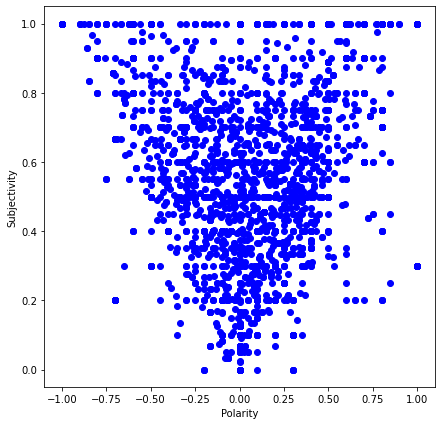

In [8]:
# Plot Polarity Vs Subjectivity

plt.subplots(figsize=(7, 7))
plt.scatter(dfsent_emotion['Polarity'], dfsent_emotion['Subjectivity'], color='b')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [9]:
# Correct some abbrevations and slang
# main correction are "i" -> "I", "i" -> "I'm", "-s" and punctuation (",", "?"), but "u" -> "you"

abb_parser = GingerIt()

for txt in emotion_pos.loc[1:10, "Tweet"]:
    print(abb_parser.parse(txt)["corrections"])

[{'start': 56, 'text': 'i', 'correct': 'I', 'definition': 'refers to the speaker or writer'}, {'start': 7, 'text': 'uber', 'correct': 'over', 'definition': 'at a higher position than'}, {'start': 0, 'text': 'indian', 'correct': 'Indian', 'definition': 'a member of the race of people living in America when Europeans arrived'}]
[{'start': 0, 'text': 'uk', 'correct': 'UK', 'definition': None}]
[{'start': 47, 'text': 'bc', 'correct': 'BC', 'definition': None}, {'start': 41, 'text': 'davis', 'correct': 'device', 'definition': 'an instrumentality invented for a particular purpose'}, {'start': 18, 'text': 'wipe', 'correct': 'wipes', 'definition': None}, {'start': 0, 'text': 'ef', 'correct': 'If', 'definition': None}]
[{'start': 42, 'text': 'willynilly', 'correct': 'willy-nilly', 'definition': 'in a random manner'}, {'start': 38, 'text': 'acc', 'correct': 'each', 'definition': '(used of count nouns) every one considered individually'}]
[]
[{'start': 61, 'text': 'u', 'correct': 'you', 'definiti

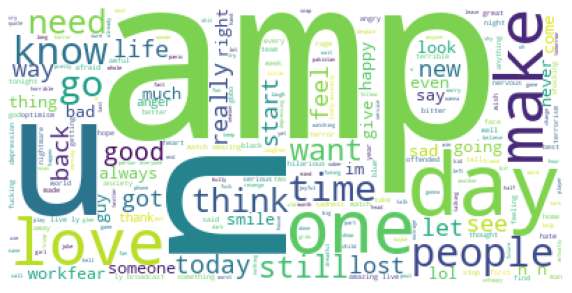

In [10]:
# Word Cloud without hashtags and stopwords

punct_withash = punct + "#" + "'"
emotion_free = clean_up(emotion_tr, text="Tweet", str_punct=punct_withash, remove_stopwd=True)
emotion_free = tk_POStag(emotion_free)

txt_string = ' '.join(emotion_free["Tweet"].tolist())
wdcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

plt.subplots(figsize=(10,10))
plt.imshow(wdcloud.generate(txt_string))
plt.axis("off")
plt.show()

## Model Training & Validation

First macro-stage where the two Neural Networks architectures are trained and evaluated according to their accuracy. In particular, one *Recurrent Neural Networks* and one *Convolutional Neural Networks* are fitted and compared using *Cross-Validation*.

In [11]:
# Clean the tweets and Count occurrences of words in all the tweets

tweet_clean = clean_up(emotion_tr, text="Tweet", str_punct=punct, remove_stopwd=True)
print(tweet_clean.shape)

def counter_wd(txt_tweets):
    count = Counter()
    for tweet in txt_tweets:
        for wd in tweet.split(" "):
            count[wd] += 1
    return count

wd_count = counter_wd(tweet_clean["Tweet"])

print(emotion_clean['Emotion'].value_counts()/emotion_clean.shape[0]) # 3/4 have almost the same distribution

(3613, 4)
fear       0.317465
anger      0.237199
joy        0.227789
sadness    0.217548
Name: Emotion, dtype: float64


In [12]:
# Text Vectorization

tknizer = Tokenizer(num_words=len(wd_count))
tknizer.fit_on_texts(tweet_clean["Tweet"])
tweetwd_idx = tknizer.word_index

tweet_seq = tknizer.texts_to_sequences(tweet_clean["Tweet"])

tweet_pad = pad_sequences(tweet_seq, padding="post", truncating="post")

print(len(tweet_seq), tweet_pad.shape)

3613 (3613, 24)


In [13]:
# One-hot encoding of the Emotions

encdr = LabelEncoder()
encdr.fit(emotion_clean["Emotion"])
y_encd = encdr.transform(emotion_clean["Emotion"])
dummy_y = np_utils.to_categorical(y_encd)

print(dummy_y.shape)

(3613, 4)


### 10-fold Cross-Validation of the Recurrent Neural Network (RNN)

In [14]:
# Cross-Validation with RNN

strat_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

y_max = dummy_y.argmax(axis=1)

for train, test in strat_kfold.split(tweet_pad, y_max):

    sequence_input = Input(shape=(24,), dtype='int32')
    embedded_sequences = Embedding(len(wd_count), 24, trainable=True)(sequence_input)
    x1 = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(embedded_sequences)
    x2 = Dense(64, activation='softmax')(x1)
    predictions = Dense(4, activation='softmax')(x2)
    mod = Model(sequence_input, predictions)

    loss = keras.losses.CategoricalCrossentropy(from_logits=False)
    optim = keras.optimizers.Adam(lr=0.001)
    metrics = ['accuracy']
    mod.compile(loss=loss, optimizer=optim, metrics=metrics)

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = mod.fit(tweet_pad[train], dummy_y[train], epochs=30, verbose=2)
    scores = mod.evaluate(tweet_pad[test], dummy_y[test], verbose=0)

    print(f'Score for fold {fold_no}: {mod.metrics_names[0]} of {scores[0]}; {mod.metrics_names[1]} of {scores[1] * 100}%')

    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
102/102 - 8s - loss: 1.3792 - accuracy: 0.2928
Epoch 2/30
102/102 - 4s - loss: 1.3758 - accuracy: 0.3174
Epoch 3/30
102/102 - 4s - loss: 1.3296 - accuracy: 0.3851
Epoch 4/30
102/102 - 4s - loss: 1.2376 - accuracy: 0.5029
Epoch 5/30
102/102 - 4s - loss: 1.1378 - accuracy: 0.6158
Epoch 6/30
102/102 - 5s - loss: 1.1014 - accuracy: 0.5970
Epoch 7/30
102/102 - 4s - loss: 1.0256 - accuracy: 0.6170
Epoch 8/30
102/102 - 4s - loss: 0.9605 - accuracy: 0.6450
Epoch 9/30
102/102 - 4s - loss: 0.9029 - accuracy: 0.6604
Epoch 10/30
102/102 - 4s - loss: 0.8577 - accuracy: 0.6699
Epoch 11/30
102/102 - 5s - loss: 0.7776 - accuracy: 0.7462
Epoch 12/30
102/102 - 4s - loss: 0.6619 - accuracy: 0.8357
Epoch 13/30
102/102 - 5s - loss: 0.5504 - accuracy: 0.8957
Epoch 14/30
102/102 - 4s - loss: 0.4528 - accuracy: 0.9360
Epoch 15/30
102/102 - 4s - loss: 0.4024 - accuracy: 0.9416
Epoch 16/30
102/102 - 4s - 

102/102 - 7s - loss: 0.9694 - accuracy: 0.5452
Epoch 8/30
102/102 - 7s - loss: 0.9470 - accuracy: 0.5366
Epoch 9/30
102/102 - 6s - loss: 0.9252 - accuracy: 0.5477
Epoch 10/30
102/102 - 6s - loss: 0.9049 - accuracy: 0.5424
Epoch 11/30
102/102 - 6s - loss: 0.8883 - accuracy: 0.5510
Epoch 12/30
102/102 - 6s - loss: 0.8771 - accuracy: 0.5510
Epoch 13/30
102/102 - 6s - loss: 0.8691 - accuracy: 0.5501
Epoch 14/30
102/102 - 6s - loss: 0.8592 - accuracy: 0.5510
Epoch 15/30
102/102 - 6s - loss: 0.8533 - accuracy: 0.5510
Epoch 16/30
102/102 - 6s - loss: 0.8654 - accuracy: 0.5461
Epoch 17/30
102/102 - 6s - loss: 0.8499 - accuracy: 0.5483
Epoch 18/30
102/102 - 6s - loss: 0.8410 - accuracy: 0.5492
Epoch 19/30
102/102 - 6s - loss: 0.8443 - accuracy: 0.5464
Epoch 20/30
102/102 - 6s - loss: 0.8356 - accuracy: 0.5492
Epoch 21/30
102/102 - 6s - loss: 0.8558 - accuracy: 0.5421
Epoch 22/30
102/102 - 6s - loss: 0.8308 - accuracy: 0.5498
Epoch 23/30
102/102 - 6s - loss: 0.8289 - accuracy: 0.5495
Epoch 24/30

Epoch 15/30
102/102 - 6s - loss: 1.1029 - accuracy: 0.4539
Epoch 16/30
102/102 - 7s - loss: 1.1055 - accuracy: 0.4530
Epoch 17/30
102/102 - 6s - loss: 1.1006 - accuracy: 0.4551
Epoch 18/30
102/102 - 6s - loss: 1.0980 - accuracy: 0.4557
Epoch 19/30
102/102 - 5s - loss: 1.0984 - accuracy: 0.4557
Epoch 20/30
102/102 - 5s - loss: 1.0954 - accuracy: 0.4569
Epoch 21/30
102/102 - 5s - loss: 1.0965 - accuracy: 0.4554
Epoch 22/30
102/102 - 5s - loss: 1.0929 - accuracy: 0.4579
Epoch 23/30
102/102 - 4s - loss: 1.1638 - accuracy: 0.4662
Epoch 24/30
102/102 - 4s - loss: 1.3019 - accuracy: 0.4702
Epoch 25/30
102/102 - 4s - loss: 1.2272 - accuracy: 0.4671
Epoch 26/30
102/102 - 4s - loss: 1.1908 - accuracy: 0.4692
Epoch 27/30
102/102 - 4s - loss: 1.1370 - accuracy: 0.4683
Epoch 28/30
102/102 - 4s - loss: 1.0109 - accuracy: 0.5200
Epoch 29/30
102/102 - 4s - loss: 0.9591 - accuracy: 0.5406
Epoch 30/30
102/102 - 4s - loss: 0.9221 - accuracy: 0.5621
Score for fold 9: loss of 1.0756107568740845; accuracy o

In [15]:
print('Score per fold:')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i + 1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')

Score per fold:
------------------------------------------------------------------------
> Fold 1 - Loss: 0.7255497574806213 - Accuracy: 76.79557800292969%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.7287683486938477 - Accuracy: 79.00552749633789%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.0719399452209473 - Accuracy: 61.049723625183105%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.042641043663025 - Accuracy: 59.556788206100464%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2171475887298584 - Accuracy: 46.81440591812134%
------------------------------------------------------------------------
> Fold 6 - Loss: 1.184831142425537 - Accuracy: 51.52354836463928%
------------------------------------------------------------------------
> Fold 7 - Loss: 1.0422163009643555 - Accuracy: 49.584487080574036%
---

In [16]:
print('Average scores for all folds:')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
clear_session()

Average scores for all folds:
> Loss: 1.0253267586231232
> Accuracy: 57.05904483795166 (+- 11.374311297204603)


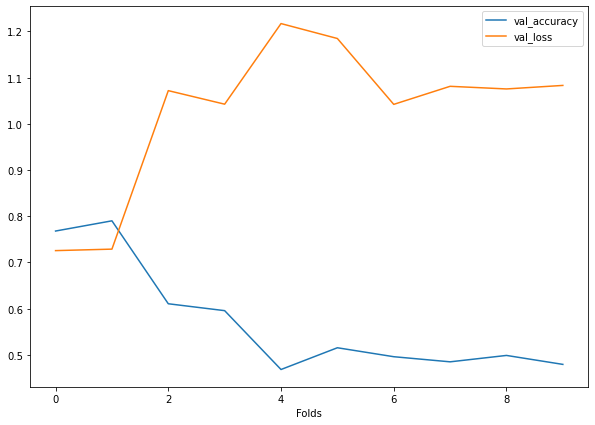

In [17]:
# Accuracy and Loss for each fold

plt.subplots(figsize=(10, 7))
plt.plot(np.array(acc_per_fold)/100)
plt.plot(loss_per_fold)
plt.legend(["val_accuracy", "val_loss"])
plt.xlabel("Folds")
plt.show()

### Validation of the Convolutional Neural Network (CNN)

In [18]:
# Cross-Validation with CNN

strat_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

y_max = dummy_y.argmax(axis=1)

for train, test in strat_kfold.split(tweet_pad, y_max):
    
    model = Sequential()
    model.add(Embedding(len(wd_count), 24, embeddings_regularizer=regularizers.l2(0.0005)))
    model.add(Conv1D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(0.0005),
                     bias_regularizer=regularizers.l2(0.0005)))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.001),
                    bias_regularizer=regularizers.l2(0.001)))
    loss = keras.losses.CategoricalCrossentropy(from_logits=False)
    optim = keras.optimizers.Adam(lr=0.001)
    metrics = ["accuracy"]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    #history = model.fit(tweet_pad[train], dummy_y[train], epochs=30, verbose=2, callbacks=[early_kstop])
    history = model.fit(tweet_pad[train], dummy_y[train], epochs=30) #, callbacks=[early_kstop])
    scores = model.evaluate(tweet_pad[test], dummy_y[test], verbose=0)

    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')

    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
102/102 [==============================] - 1s 4ms/step - loss: 1.4460 - accuracy: 0.2965
Epoch 2/30
102/102 [==============================] - 0s 4ms/step - loss: 1.3144 - accuracy: 0.3793
Epoch 3/30
102/102 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.8907
Epoch 4/30
102/102 [==============================] - 0s 4ms/step - loss: 0.3580 - accuracy: 0.9464
Epoch 5/30
102/102 [==============================] - 0s 4ms/step - loss: 0.2687 - accuracy: 0.9684
Epoch 6/30
102/102 [==============================] - 0s 5ms/step - loss: 0.2534 - accuracy: 0.9720
Epoch 7/30
102/102 [==============================] - 0s 5ms/step - loss: 0.2296 - accuracy: 0.9772
Epoch 8/30
102/102 [==============================] - 0s 4ms/step - loss: 0.2195 - accuracy: 0.9799
Epoch 9/30
102/102 [==============================] - 0s 4ms/step - loss: 0.2162 - accuracy: 0.9862
Epo

Epoch 18/30
102/102 [==============================] - 0s 5ms/step - loss: 0.2127 - accuracy: 0.9771
Epoch 19/30
102/102 [==============================] - 0s 5ms/step - loss: 0.2095 - accuracy: 0.9790
Epoch 20/30
102/102 [==============================] - 0s 5ms/step - loss: 0.2076 - accuracy: 0.9828
Epoch 21/30
102/102 [==============================] - 0s 5ms/step - loss: 0.2069 - accuracy: 0.9813
Epoch 22/30
102/102 [==============================] - 0s 5ms/step - loss: 0.2061 - accuracy: 0.9811
Epoch 23/30
102/102 [==============================] - 0s 5ms/step - loss: 0.2054 - accuracy: 0.9830
Epoch 24/30
102/102 [==============================] - 0s 5ms/step - loss: 0.2005 - accuracy: 0.9842
Epoch 25/30
102/102 [==============================] - 0s 5ms/step - loss: 0.2019 - accuracy: 0.9831
Epoch 26/30
102/102 [==============================] - 0s 5ms/step - loss: 0.2058 - accuracy: 0.9815
Epoch 27/30
102/102 [==============================] - 0s 5ms/step - loss: 0.2021 - accurac

102/102 [==============================] - 0s 4ms/step - loss: 0.3620 - accuracy: 0.9497
Epoch 5/30
102/102 [==============================] - 0s 4ms/step - loss: 0.2900 - accuracy: 0.9626
Epoch 6/30
102/102 [==============================] - 0s 5ms/step - loss: 0.2451 - accuracy: 0.9756
Epoch 7/30
102/102 [==============================] - 0s 4ms/step - loss: 0.2367 - accuracy: 0.9744
Epoch 8/30
102/102 [==============================] - 0s 4ms/step - loss: 0.2252 - accuracy: 0.9797
Epoch 9/30
102/102 [==============================] - 0s 4ms/step - loss: 0.2277 - accuracy: 0.9790
Epoch 10/30
102/102 [==============================] - 0s 4ms/step - loss: 0.2132 - accuracy: 0.9848
Epoch 11/30
102/102 [==============================] - 0s 4ms/step - loss: 0.2143 - accuracy: 0.9801
Epoch 12/30
102/102 [==============================] - 0s 4ms/step - loss: 0.2091 - accuracy: 0.9829
Epoch 13/30
102/102 [==============================] - 0s 4ms/step - loss: 0.2095 - accuracy: 0.9832
Epoch 1

102/102 [==============================] - 0s 5ms/step - loss: 0.1965 - accuracy: 0.9872
Epoch 23/30
102/102 [==============================] - 0s 5ms/step - loss: 0.1965 - accuracy: 0.9840
Epoch 24/30
102/102 [==============================] - 0s 5ms/step - loss: 0.1953 - accuracy: 0.9839
Epoch 25/30
102/102 [==============================] - 0s 5ms/step - loss: 0.1936 - accuracy: 0.9874
Epoch 26/30
102/102 [==============================] - 0s 5ms/step - loss: 0.1958 - accuracy: 0.9834
Epoch 27/30
102/102 [==============================] - 0s 5ms/step - loss: 0.1915 - accuracy: 0.9875
Epoch 28/30
102/102 [==============================] - 0s 5ms/step - loss: 0.1935 - accuracy: 0.9843
Epoch 29/30
102/102 [==============================] - 0s 5ms/step - loss: 0.1931 - accuracy: 0.9862
Epoch 30/30
102/102 [==============================] - 0s 5ms/step - loss: 0.1878 - accuracy: 0.9890
Score for fold 8: loss of 0.6124088168144226; accuracy of 83.65650773048401%
--------------------------

In [19]:
print('Score per fold:')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i + 1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')

Score per fold:
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5762433409690857 - Accuracy: 83.14917087554932%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.48305046558380127 - Accuracy: 88.39778900146484%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.4808255732059479 - Accuracy: 88.12154531478882%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.5722761750221252 - Accuracy: 83.65650773048401%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.49067553877830505 - Accuracy: 87.25761771202087%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.47020551562309265 - Accuracy: 88.0886435508728%
------------------------------------------------------------------------
> Fold 7 - Loss: 0.45038357377052307 - Accuracy: 86.98061108589172%
-

In [20]:
print('Average scores for all folds:')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')

clear_session()

Average scores for all folds:
> Loss: 0.5139369815587997
> Accuracy: 86.29926025867462 (+- 1.9974370912389794)


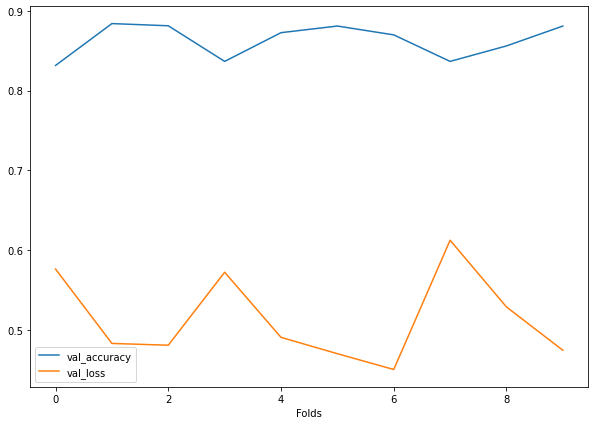

In [21]:
# Accuracy and Loss for each fold

plt.subplots(figsize=(10, 7))
plt.plot(np.array(acc_per_fold)/100)
plt.plot(loss_per_fold)
plt.legend(["val_accuracy", "val_loss"])
plt.xlabel("Folds")
plt.show()

### EarlyStopping to reduce overfitting on the CNN

Re-train of the best neural network architecture, the CNN, on the entire training set, in combination with the *EarlyStopping* regularization method to limit the overfitting of the model on the WASSA-2017 Development set.

In [22]:
# Import the DEVELOPMENT SET provided for four emotions: "anger", "fear", "joy" and "sadness"

anger_dev = pd.read_csv("anger-ratings-0to1.dev.gold.txt", sep="	", header=None, names=col_names)
fear_dev = pd.read_csv("fear-ratings-0to1.dev.gold.txt", sep="	", header=None, names=col_names)
joy_dev = pd.read_csv("joy-ratings-0to1.dev.gold.txt", sep="	", header=None, names=col_names)
sadness_dev = pd.read_csv("sadness-ratings-0to1.dev.gold.txt", sep="	", header=None, names=col_names)

emotion_dev = pd.concat([anger_dev, fear_dev, joy_dev, sadness_dev], axis=0)

print(anger_dev.shape, fear_dev.shape, joy_dev.shape, sadness_dev.shape)
print('\nAggregate size of the Development set: {}'.format(emotion_dev.shape))

(84, 4) (110, 4) (79, 4) (74, 4)

Aggregate size of the Development set: (347, 4)


In [23]:
# Clean the Development set and re-train the Neural Network

dev_clean = clean_up(emotion_dev, text="Tweet", str_punct=punct, remove_stopwd=True)

dev_seq = tknizer.texts_to_sequences(dev_clean["Tweet"])

dev_pad = pad_sequences(dev_seq, maxlen=24, padding="post", truncating="post")

dev_trencd = encdr.transform(dev_clean['Emotion'])
dummy_dev = np_utils.to_categorical(dev_trencd) # convert integers to dummy variables (i.e. one hot encoded)

model = Sequential()
model.add(Embedding(len(wd_count), 24, embeddings_regularizer=regularizers.l2(0.0005)))
model.add(Conv1D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(tweet_pad, dummy_y, validation_data=(dev_pad, dummy_dev), epochs=30,
                    callbacks=[EarlyStopping(monitor="val_accuracy", mode="max", min_delta=0.005, patience=10, 
                                             restore_best_weights=True)])

clear_session()

Epoch 1/30
113/113 [==============================] - 4s 22ms/step - loss: 1.4401 - accuracy: 0.3148 - val_loss: 1.3802 - val_accuracy: 0.3170
Epoch 2/30
113/113 [==============================] - 1s 6ms/step - loss: 1.2834 - accuracy: 0.4201 - val_loss: 0.8635 - val_accuracy: 0.8242
Epoch 3/30
113/113 [==============================] - 1s 6ms/step - loss: 0.6337 - accuracy: 0.9065 - val_loss: 0.5165 - val_accuracy: 0.8473
Epoch 4/30
113/113 [==============================] - 1s 6ms/step - loss: 0.3448 - accuracy: 0.9493 - val_loss: 0.5138 - val_accuracy: 0.8501
Epoch 5/30
113/113 [==============================] - 1s 6ms/step - loss: 0.2751 - accuracy: 0.9663 - val_loss: 0.5234 - val_accuracy: 0.8617
Epoch 6/30
113/113 [==============================] - 1s 6ms/step - loss: 0.2568 - accuracy: 0.9698 - val_loss: 0.5322 - val_accuracy: 0.8559
Epoch 7/30
113/113 [==============================] - 1s 7ms/step - loss: 0.2347 - accuracy: 0.9783 - val_loss: 0.5489 - val_accuracy: 0.8444
Epoch

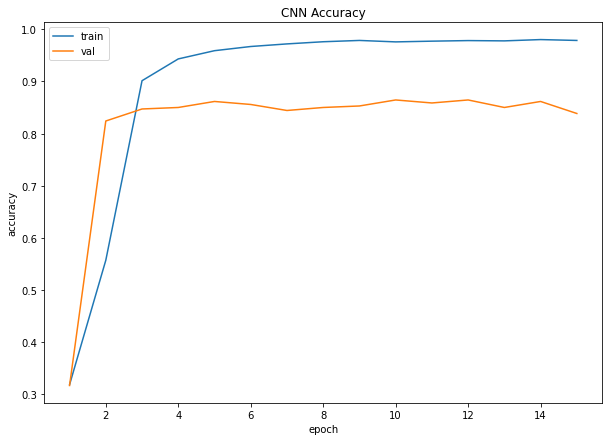

In [24]:
# Validation and Training Accuracy for each epoch

plt.subplots(figsize=(10, 7))
plt.plot(range(1,16), history.history['accuracy'])
plt.plot(range(1,16), history.history['val_accuracy'])
plt.title('CNN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

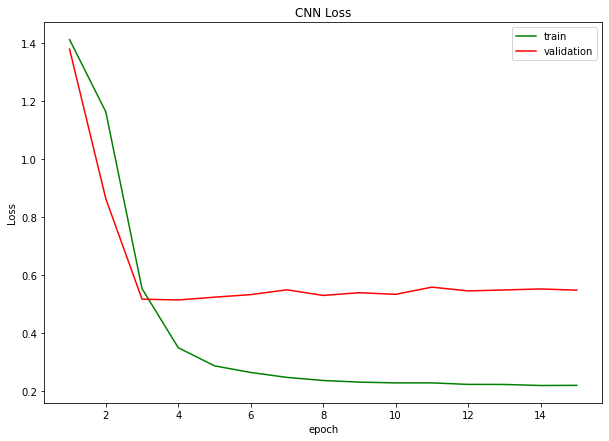

In [26]:
# Validation and Training loss for each epoch

plt.subplots(figsize=(10, 7))
plt.plot(range(1,16), history.history['loss'], c='green')
plt.plot(range(1,16), history.history['val_loss'], c='red')
plt.title('CNN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [27]:
# Inspect the explanation of the predictions made by the Neural Network Classifier with LIME

emote_names = ['anger', 'fear', 'joy', 'sadness']
explainer = LimeTextExplainer(class_names=emote_names)

def lime_pred(texts):
    _seq = tknizer.texts_to_sequences(texts)
    _textdata = pad_sequences(_seq, maxlen=24, padding='post', truncating='post')
    return model.predict(_textdata)

np.random.seed(1001)
random_idx = np.random.randint(low=0, high=tweet_clean.shape[0], size=1)[0]

print(tweet_clean.loc[random_idx, 'Tweet'])
print('Predictions: {}'.format(np.round(lime_pred([tweet_clean.loc[random_idx, 'Tweet']]), 3)))
print('\nTrue label is: {} \nwith encoding: {}'.format(tweet_clean.loc[random_idx, 'Emotion'], dummy_y[random_idx]))

tell i'm supposed feel #broken #hateful #guilty #love #sadness
Predictions: [[0.012 0.007 0.013 0.968]]

True label is: sadness 
with encoding: [0. 0. 0. 1.]


In [28]:
# Explanation

exp = explainer.explain_instance(tweet_clean.loc[random_idx, 'Tweet'], lime_pred, labels=emote_names, num_features=24, num_samples=2890, top_labels=4)

# negative weights decrease the probability of the emotions predicted
print('Explanation as list of weighted word features: {}'.format(exp.as_list(label=0)))

Explanation as list of weighted word features: [('sadness', -0.23057978715906788), ('love', -0.033032268974838935), ('supposed', 0.012392806295623343), ('broken', -0.010109648159505356), ('guilty', 0.009064333382240343), ('feel', -0.00893673927553698), ('hateful', 0.005510369589268362), ('tell', -0.003055186678595372), ('m', -0.0021998498858208167), ('i', -0.00026211732901051786)]


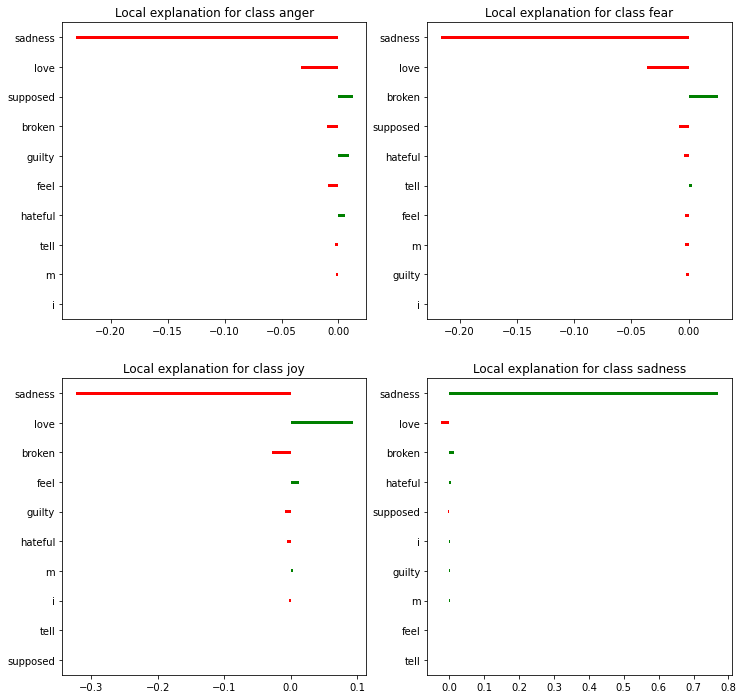

In [29]:
# Visual representation of the explanation

fig, axes = plt.subplots(2, 2, figsize=(12,12))

for i, ax in zip(range(4), axes.flatten()):
    exp_l = exp.as_list(label=i)
    vals = [x[1] for x in exp_l]
    names = [x[0] for x in exp_l]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(exp_l)) + .5
    ax.barh(pos, vals, align='center', color=colors, height=0.1)
    ax.set_yticks(pos)
    ax.set_yticklabels(names)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(10)
    ax.set_title(str('Local explanation for class %s' % exp.class_names[i]))
    plt.setp(ax.get_yticklabels(), visible=True)

---

## Song Classification & Playlist Creation

Second macro-stage where the songs lyrics are cleaned and split into sentences that would be used to compute the predicted probabilities for each emotion by means of the best model. Then, an heuristic rule would be chosen as a criterion to convert the predicitions into one or multiple emotions.

Url-link to the lyrics dataset: <https://www.kaggle.com/imuhammad/audio-features-and-lyrics-of-spotify-songs>

In [30]:
# Import the dataset with song's title, artist, lyrics and genre

songs_df = pd.read_csv("spotify_songs.csv", sep=",", header=0)
print(songs_df.shape)
print(songs_df.columns)

(18454, 25)
Index(['track_id', 'track_name', 'track_artist', 'lyrics', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'language'],
      dtype='object')


In [31]:
# Filter the english songs

eng_songs = songs_df[songs_df['language'] == 'en'].loc[:, ['track_name', 'track_artist', 'lyrics', 'playlist_genre']]
eng_songs.columns = ['Name', 'Artist', 'Lyrics', 'Genre']
eng_songs = eng_songs.reset_index(drop=True)
print(eng_songs.shape, eng_songs.head())

(15405, 4)                                                 Name          Artist  \
0                                       I Feel Alive   Steady Rollin   
1                                             Poison  Bell Biv DeVoe   
2  Baby It's Cold Outside (feat. Christina Aguilera)     CeeLo Green   
3                                         Dumb Litty            KARD   
4                                            Soldier        James TW   

                                              Lyrics Genre  
0  The trees, are singing in the wind The sky blu...  rock  
1  NA Yeah, Spyderman and Freeze in full effect U...   r&b  
2  I really can't stay Baby it's cold outside I'v...   r&b  
3  Get up out of my business You don't keep me fr...   pop  
4  Hold your breath, don't look down, keep trying...   r&b  


In [32]:
# Split the lyrics in sentences and clean them

def sent_and_clean(txt):

    str_punct = punctuation.replace("#", "").replace("'", "") + "—" + "“" + "’" + "€" + "£"
    listof = []

    txt_ascii = " ".join(txt.encode("ascii", errors="ignore").decode().split())
    sent_list = nltk.tokenize.sent_tokenize(txt_ascii)

    for sent in sent_list:
        sent_clean = sent.encode("ascii", errors="ignore").decode() # remove weird characters like '오늘 밤 지나 해가 뜰 때까지 계속'
        sent_clean = sent_clean.lower().translate(str.maketrans(str_punct, ' ' * len(str_punct))) # remove punctuation
        sent_clean = " ".join([wd for wd in nltk.word_tokenize(sent_clean) if wd not in stopwords.words("english")]) # remove stopwords and append
        sent_clean = re.sub(r'\d+', '', sent_clean) # remove digits
        sent_clean = " ".join([wd for wd in nltk.word_tokenize(sent_clean) if wd not in ["'s", "n't", "'re", "'ll", "'m", "'", "'ve", "'d", "'cuz"
                                                                                         "'til", "till", "i'mma", "'cause", "'em", "'ma"]]) # remove abbreviations

        if len(sent_clean.split()) > 2:
            listof.append(sent_clean)

    return listof

eng_songs['Sentences'] = eng_songs['Lyrics'].apply(sent_and_clean)

subset_songs = eng_songs[eng_songs['Sentences'].map(len) > 1]
subset_songs = subset_songs.reset_index(drop=True)

subset_songs.head()

,Name,Artist,Lyrics,Genre,Sentences
0,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",rock,[trees singing wind sky blue angels smiled saw...
1,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",r&b,[na yeah spyderman freeze full effect uh huh r...
2,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,r&b,[really ca stay baby cold outside got go away ...
3,Satisfy You,Diddy,All I want is somebody who's gonna love me for...,r&b,[want somebody gon na love somebody love money...
4,Limestone,Magic City Hippies,How many friends are you gonna set on fire? Ho...,pop,"[many friends gon na set fire, many hearts gon..."


In [33]:
# Extract the padded sequences ONLY for lists with length lower than 24 (maximum of the tweets)

def sent_to_padseq(list_txt):

    pads_list = []
    if len(list_txt) > 1:
        for lis in list_txt:
            if len(lis.split()) <= 24:
                sent_seq = tknizer.texts_to_sequences([lis])
                sent_pad = pad_sequences(sent_seq, maxlen=24, padding="post", truncating="post").tolist()[0]
                pads_list.append(sent_pad)

    return pads_list

lyrics_pad = subset_songs['Sentences'].copy().apply(sent_to_padseq)
subset_songs['Padding'] = lyrics_pad

subset_songs = subset_songs[subset_songs['Padding'].map(len) > 0]
subset_songs = subset_songs.reset_index(drop=True)

subset_songs.head()

,Name,Artist,Lyrics,Genre,Sentences,Padding
0,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",rock,[trees singing wind sky blue angels smiled saw...,"[[3595, 1067, 94, 1284, 7094, 3380, 3549, 4151..."
1,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",r&b,[na yeah spyderman freeze full effect uh huh r...,"[[1593, 296, 391, 2447, 535, 8095, 0, 0, 0, 0,..."
2,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,r&b,[really ca stay baby cold outside got go away ...,"[[30, 4202, 619, 810, 1021, 514, 25, 16, 102, ..."
3,Limestone,Magic City Hippies,How many friends are you gonna set on fire? Ho...,pop,"[many friends gon na set fire, many hearts gon...","[[237, 328, 1593, 854, 315, 0, 0, 0, 0, 0, 0, ..."
4,Changes,2Pac,"I see no changes, wake up in the morning and I...",rap,[see changes wake morning ask life worth livin...,"[[27, 1094, 474, 157, 779, 36, 836, 0, 0, 0, 0..."


In [34]:
# Create a Ragged Tensor [6656, max_padseq, 4] to store the predictions of the model

def pred_tensor(pad_column):
    list_arrays = []

    for elem in pad_column:
        pred = model.predict(elem)
        list_arrays.append(pred)

    rag_tensor = tf.ragged.constant(list_arrays)
    return rag_tensor

tensor_probabilities = pred_tensor(subset_songs['Padding'].values)
print(tensor_probabilities.shape)
print('Tensor dimensions: {}'.format(tensor_probabilities.bounding_shape()))

(6656, None, None)
Tensor dimensions: [6656  152    4]


In [35]:
# Get the max by columns for each row, representing the prevalent emotion for each sentence in a song

def get_maxEmotion(prob_tensor):
    list_max = []

    for array in prob_tensor:
        np_array = array.numpy()
        max_idx = np.argmax(np_array, axis=1)
        if max_idx.shape[0] > 1:
            list_max.append([[x] for x in np.transpose(max_idx).tolist()])
        else:
            list_max.append([max_idx])

    max_tensor = tf.ragged.constant(list_max)
    return max_tensor

tensor_maxprob = get_maxEmotion(tensor_probabilities)
print(tensor_maxprob.shape)
print('Tensor dimensions: {}'.format(tensor_maxprob.bounding_shape()))

(6656, None, None)
Tensor dimensions: [6656  152    1]


In [36]:
# Frequencies of emotions with respect to each song at their corresponding index position 
# 0-anger 1-fear 2-joy 3-sadness

def get_emotefreq(max_tensor):
    list_freq = []

    for array in max_tensor:
        default_freq = [0, 0, 0, 0]

        np_array = array.numpy()
        array_freq = np.unique(np_array, return_counts=True)

        if array_freq[0].shape[0] < 4: # If not all the emotions are included, then set their frequencies to zero
            valfreq_tup = list(zip(array_freq[0], array_freq[1]))
            for val, freq in valfreq_tup:
                default_freq[val] = freq
            list_freq.append(default_freq)

        else:
            list_freq.append(array_freq[1].tolist())

    freq_numpy = np.array(list_freq)
    return freq_numpy

array_songfreq = get_emotefreq(tensor_maxprob)

array_songfreq[:10]

array([[ 0,  1,  0,  0],
       [ 2,  6,  7,  0],
       [ 1,  2,  1,  0],
       [ 2,  0,  4,  0],
       [ 2,  0,  1,  0],
       [ 5,  1,  0,  1],
       [16,  1,  0,  1],
       [ 0,  0,  3,  0],
       [13,  0,  1,  0],
       [ 0,  8,  0,  0]])

In [37]:
# Heuristic rule suitable for multi-label classification of the songs
# Cutoff: 0.25 (25%) to consider a song having that emotion

def classify_emote(emote_counts, perc_rule):
    list_class = []
    class_voc = dict([(0, 'anger'), (1, 'fear'), (2, 'joy'), (3, 'sadness')])

    for song in emote_counts:
        satisfy_idx = [idx for idx, val in enumerate(song.tolist()) if val/np.sum(song) >= perc_rule]
        satisfy_class = [class_voc[idx] for idx in satisfy_idx]
        list_class.append(satisfy_class)

    #class_tensor = tf.ragged.constant(list_class, dtype=tf.dtypes.string)
    return pd.Series(list_class, name='Classification')

# Fix the encoding of the strings in the tensor
subset_songs['Classification'] = classify_emote(array_songfreq, perc_rule=0.25)

print(subset_songs['Classification'].value_counts())

[anger]                        1482
[fear]                         1308
[anger, fear]                  1117
[joy]                           741
[anger, joy]                    491
[fear, joy]                     430
[sadness]                       340
[anger, fear, joy]              191
[anger, sadness]                168
[fear, sadness]                 145
[joy, sadness]                   80
[anger, fear, sadness]           74
[anger, joy, sadness]            47
[fear, joy, sadness]             29
[anger, fear, joy, sadness]      13
Name: Classification, dtype: int64


In [38]:
# Inspect the distributions of the multi-label emotions for wrt to the 'Genre'

tuple_classify = []

for elem in subset_songs.loc[:, ['Genre', 'Classification']].values:
    tuple_classify.append((elem[0], elem[1]))

In [39]:
# Combination of genres and emotions

def unique_tup(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
        else:
            continue

    return unique_list

uniq_genremote = unique_tup(tuple_classify)

print(uniq_genremote, len(uniq_genremote))

[('rock', ['fear']), ('r&b', ['fear', 'joy']), ('r&b', ['anger', 'fear', 'joy']), ('pop', ['anger', 'joy']), ('rap', ['anger', 'joy']), ('rock', ['anger']), ('r&b', ['anger']), ('pop', ['joy']), ('pop', ['anger']), ('rap', ['fear']), ('rap', ['anger']), ('rap', ['anger', 'fear']), ('pop', ['fear', 'sadness']), ('edm', ['anger', 'joy']), ('latin', ['fear']), ('rap', ['fear', 'joy']), ('rock', ['anger', 'sadness']), ('rap', ['joy']), ('rock', ['joy']), ('rock', ['anger', 'joy']), ('rock', ['fear', 'sadness']), ('pop', ['fear']), ('r&b', ['fear']), ('r&b', ['joy']), ('rock', ['anger', 'fear', 'sadness']), ('rock', ['sadness']), ('pop', ['anger', 'sadness']), ('edm', ['fear']), ('rap', ['sadness']), ('r&b', ['anger', 'fear']), ('rock', ['anger', 'fear', 'joy']), ('pop', ['fear', 'joy']), ('rap', ['anger', 'fear', 'sadness']), ('rock', ['anger', 'fear']), ('edm', ['joy']), ('edm', ['anger', 'fear']), ('edm', ['anger']), ('edm', ['sadness']), ('r&b', ['anger', 'joy']), ('rap', ['anger', 'sad

In [40]:
# Absolute frequencies of songs and genres

dict_genremote = dict()

for el in uniq_genremote:
    create_key = (el[0], )
    for emot in el[1]:
        create_key = create_key + (emot, )
    dict_genremote[create_key] = tuple_classify.count(el)

for key, val in sorted(dict_genremote.items(), key=lambda x: x[1], reverse=True):
    print(str(key) + ' : ' + str(val))

('rap', 'anger', 'fear') : 377
('pop', 'anger') : 343
('rap', 'anger') : 317
('r&b', 'fear') : 307
('pop', 'fear') : 302
('rock', 'anger') : 297
('r&b', 'anger') : 297
('rap', 'fear') : 292
('rock', 'fear') : 240
('r&b', 'anger', 'fear') : 229
('pop', 'joy') : 210
('pop', 'anger', 'fear') : 203
('rock', 'anger', 'fear') : 193
('r&b', 'joy') : 163
('edm', 'anger') : 148
('rock', 'joy') : 145
('rock', 'anger', 'joy') : 117
('edm', 'fear') : 115
('pop', 'fear', 'joy') : 113
('r&b', 'anger', 'joy') : 107
('pop', 'anger', 'joy') : 102
('rap', 'joy') : 97
('rap', 'anger', 'joy') : 94
('r&b', 'fear', 'joy') : 92
('pop', 'sadness') : 92
('rock', 'fear', 'joy') : 85
('latin', 'anger') : 80
('rap', 'fear', 'joy') : 75
('rock', 'sadness') : 73
('edm', 'joy') : 72
('edm', 'anger', 'fear') : 67
('r&b', 'sadness') : 61
('rap', 'sadness') : 57
('latin', 'joy') : 54
('latin', 'fear') : 52
('rock', 'anger', 'fear', 'joy') : 50
('edm', 'anger', 'joy') : 48
('latin', 'anger', 'fear') : 48
('pop', 'anger'

In [41]:
# Create dummies for the emotions classification of the songs

s = subset_songs['Classification']
mlb = MultiLabelBinarizer()

subset_songs = pd.concat([subset_songs, pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=subset_songs.index)], axis=1)
subset_songs.head()

,Name,Artist,Lyrics,Genre,Sentences,Padding,Classification,anger,fear,joy,sadness
0,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",rock,[trees singing wind sky blue angels smiled saw...,"[[3595, 1067, 94, 1284, 7094, 3380, 3549, 4151...",[fear],0,1,0,0
1,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",r&b,[na yeah spyderman freeze full effect uh huh r...,"[[1593, 296, 391, 2447, 535, 8095, 0, 0, 0, 0,...","[fear, joy]",0,1,1,0
2,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,r&b,[really ca stay baby cold outside got go away ...,"[[30, 4202, 619, 810, 1021, 514, 25, 16, 102, ...","[anger, fear, joy]",1,1,1,0
3,Limestone,Magic City Hippies,How many friends are you gonna set on fire? Ho...,pop,"[many friends gon na set fire, many hearts gon...","[[237, 328, 1593, 854, 315, 0, 0, 0, 0, 0, 0, ...","[anger, joy]",1,0,1,0
4,Changes,2Pac,"I see no changes, wake up in the morning and I...",rap,[see changes wake morning ask life worth livin...,"[[27, 1094, 474, 157, 779, 36, 836, 0, 0, 0, 0...","[anger, joy]",1,0,1,0


In [42]:
# Create Playlist based on user's mood and preferences

def playlist_moodgenre(user_mood, user_genre, play_length=100, seed=42):
    play_songs = []
    play_artists = []

    for emot in user_mood:
        for gen in user_genre:
            songs = subset_songs[subset_songs["Genre"] == gen]
            play_songs.extend(songs[songs[emot] == 1]["Name"].to_list())
            play_artists.extend(songs[songs[emot] == 1]["Artist"].to_list())

    playlist = pd.concat([pd.Series(play_songs, name="Song"), pd.Series(play_artists, name="Artist")], axis=1).sample(n=len(play_songs), random_state=seed)
    return playlist.iloc[:play_length].reset_index(drop=True)

### Spotify API

- Use the Spotify API to create the playlists based on the recommendations obtained from the neural networks

- github code of authentication process for the Spotify API and search query <https://github.com/codingforentrepreneurs/30-Days-of-Python/blob/master/tutorial-reference/Day%2019/notebooks/5%20-%20Robust%20Query%20Search.ipynb>

- github code of "create_playlist()": <https://github.com/TheComeUpCode/SpotifyGeneratePlaylist/blob/master/create_playlist.py>

- URL-link to refresh the "playlist_token": <https://developer.spotify.com/console/post-playlists/?user_id=&body=%7B%22name%22%3A%22New%20Playlist%22%2C%22description%22%3A%22New%20playlist%20description%22%2C%22public%22%3Afalse%7D>


In [43]:
# Client Credential Flows

client_id = '3784ed3175ef4dc993f7434bc1ce2a16'
client_secret = '8980ef68b0af40e3820a4b4609a51336'

class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"

    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret

    def get_client_credentials(self):
        """
        Returns a base64 encoded string
        """
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()

    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        return {
            "Authorization": f"Basic {client_creds_b64}"
        }

    def get_token_data(self):
        return {
            "grant_type": "client_credentials"
        }

    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data=token_data, headers=token_headers)
        if r.status_code not in range(200, 299):
            raise Exception("Could not authenticate client.")
            # return False
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in']  # seconds
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True

    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token()
        return token

    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
        }
        return headers

    def get_resource(self, lookup_id, resource_type='albums', version='v1'):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()

    def get_album(self, _id):
        return self.get_resource(_id, resource_type='albums')

    def get_artist(self, _id):
        return self.get_resource(_id, resource_type='artists')

    def base_search(self, query_params):  # type
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        lookup_url = f"{endpoint}?{query_params}"
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()

    def search(self, query=None, operator=None, operator_query=None, search_type='artist'):
        if query == None:
            raise Exception("A query is required")
        if isinstance(query, dict):
            query = " ".join([f"{k}:{v}" for k, v in query.items()])
        if operator != None and operator_query != None:
            if operator.lower() == "or" or operator.lower() == "not":
                operator = operator.upper()
                if isinstance(operator_query, str):
                    query = f"{query} {operator} {operator_query}"
        query_params = urlencode({"q": query, "type": search_type.lower()})
        print(query_params)
        return self.base_search(query_params)

spotify = SpotifyAPI(client_id, client_secret)
print(spotify.perform_auth())
access_token = spotify.get_access_token()
print(access_token)

True
BQDqGve2lqTLp77H3sqyUA5RhfLbalu1A_04Nm7bETqh38lxIrQWRizcnhYw5v2shMuq7EXmQ3SOrwxYLlE


In [44]:
# Set my mood and favourite genres - Create a playlist and add it to my Spotify student account

class Spotify_Playlist():

    def __init__(self, client_id, client_secret):
        spotify_play = SpotifyAPI(client_id, client_secret)
        if spotify_play.perform_auth():
            print("Correctly Authenticated")
            print("Access Token: " + spotify.get_access_token())
        else:
            print("Error - Check SpotifyAPI() code")

        self.spotify_play = spotify_play

    def create_playlist(self,  playlist_token, user_name, user_id='2v9b8tr4wg6dkolxr7g9qhs73'):
        request_body = json.dumps({"name": "Sentiment Analysis - {}'s Playlist".format(user_name),
                                   "description": 'Playlist implemented by using Neural Networks to combine emotions and genres', "public": True})
        query = "https://api.spotify.com/v1/users/{}/playlists".format(user_id)
        response = requests.post(query, data=request_body, headers={"Content-Type": "application/json", "Authorization": "Bearer {}".format(playlist_token)})
        response_json = response.json()
        playlist_id = response_json['id']

        self.playlist_id = playlist_id
        self.playlist_token = playlist_token
        return playlist_id

    def add_tracks(self, user_mood, user_genre, play_length=100, seed=42):
        user_pred = playlist_moodgenre(user_mood, user_genre, play_length, seed)
        uris = []
        not_found = []

        for song, artist in zip(user_pred["Song"], user_pred["Artist"]):
            q_result = self.spotify_play.search({'track': song, 'artist': artist}, search_type="track")

            if len(q_result['tracks']['items']) == 0:
                not_found.append(song + ' by ' + artist )
                continue
            else:
                uris.append(q_result['tracks']['items'][0]['uri'])

        request_data = json.dumps(uris)
        query = "https://api.spotify.com/v1/playlists/{}/tracks".format(self.playlist_id)
        response = requests.post(query, data=request_data, headers={"Content-Type": "application/json", "Authorization": "Bearer {}".format(self.playlist_token)})

        if response.status_code != 200:
            print("Error in the status code: {}".format({response.status_code}))

        self.not_found = not_found
        response_json = response.json()
        return response_json

sp = Spotify_Playlist(client_id, client_secret)

sp.create_playlist('BQCKUuF_H2cjD7CkjBQllgvGwUBKpVB-w2OHO1jivIHlBXEYKiWitlUO1I6OlIviGASBHDfCAZZPAktcAYE7RJBc5WI1qOfyz-GmXem1LFPvYe6MQhbHlZ3X15yxIJBPIOBoE7Us0oeySY6rmO4nNPKyHMF612qY5RjyDy_EPjUqyWi2zpR1i1xgA3qY9YAx914',
                   user_name='Francesco - Multilabel') 

Correctly Authenticated
Access Token: BQDqGve2lqTLp77H3sqyUA5RhfLbalu1A_04Nm7bETqh38lxIrQWRizcnhYw5v2shMuq7EXmQ3SOrwxYLlE


'47YGcwFA5yrLQdposzvWI7'

In [ ]:
# Playlist created: Multiclass and Multilabel Classification

# User 1: Francesco (96 songs) [Multiclass]
sp.add_tracks(user_mood=["joy", "anger"], user_genre=["rap", "pop", "rock"])
print(sp.not_found)

# User 2: Filippo (94 songs) [Multiclass]
sp.add_tracks(user_mood=["anger", "sadness"], user_genre=["rock", "rap"])
print(sp.not_found)

# User 3: Andrea (89 songs) [Multiclass]
sp.add_tracks(user_mood=["anger"], user_genre=["rap", "rock"])
print(sp.not_found)

# User 4: Paolo (88 songs) [Multiclass]
sp.add_tracks(user_mood=["Fear"], user_genre=["edm"])
print(sp.not_found)

# User 5: Ornella (97 songs) [Multiclass]
sp.add_tracks(user_mood=["fear", "sadness"], user_genre=["latin", "rap", "pop"])
print(sp.not_found)

# User 6: Danila (91 songs) [Multiclass]
sp.add_tracks(user_mood=["sadness", "fear"], user_genre=["pop", "r&b", "rap", "latin"])
print(sp.not_found)

# User 7: Francesco (Me) [Multilabel Classification]
sp.add_tracks(user_mood=["fear", "anger", "sadness"], user_genre=["rock", "rap", "pop"])
print(sp.not_found)

# User 8: Floriana-Grazia-Noemi [Multilabel Classification]
sp.add_tracks(user_mood=["sadness", "fear", "joy"], user_genre=["pop", "rock", "rap"])
print(sp.not_found)

# User 9: Leonardo [Multilabel Classification]
sp.add_tracks(user_mood=["anger", "joy"], user_genre=["rap", "rock", "edm"])
print(sp.not_found)